# Convolutional Variational Autoencoder Implementation for Reconstruction of CartoonFaces dataset

In this notebook we train a Variational Autoencoder (VAE) on the CartoonFaces dataset (https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set). The VAE is a type of autoencoder probabilistic. So instead of leatting our neural network learn an arbitrary function, we are learning the parameters of a probability distribution modeling our data.

### Import the dataset from Kaggle

In [1]:
import kaggle

In [2]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

cartoon-faces-googles-cartoon-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import os
from glob import glob
 

DATA_FOLDER = './cartoonset100k_jpg/cartoonset100k_jpg/'


#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('cartoon-faces-googles-cartoon-set.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./cartoonset100k_jpg/')

### Setup

In [4]:
import numpy as np

import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [5]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 100000


### Generate batch

Since using the whole dataset would be very computational expensive we are only using a batch of 512 images.

In [6]:
INPUT_DIM = (512,512,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 128 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 100000 images belonging to 10 classes.


### Define the architecture of our encoder and decoder networks 

In this VAE example, we use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively.  Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation $x$ and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 


### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation $x$. Model the latent distribution prior $p(z)$ as a unit Gaussian.


### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use four convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by five convolution transpose layers (a.k.a. deconvolutional layers in some contexts). 

### Create a sampling layer

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Build the encoder

In [8]:
latent_dim = Z_DIM

encoder_inputs = keras.Input(shape=INPUT_DIM)


x = layers.Conv2D(8, 3, strides=2, padding="same")(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

#x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
#x = layers.LeakyReLU(0.2)(x)

#x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
#x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.40)(x)

x = layers.Dense(512)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="Encoder")
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  1168        ['leaky_re_lu[0][0]']      

### Build the decoder

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(512)(latent_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(8*8*128)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Reshape((8,8,128))(x)

#x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
#x = layers.LeakyReLU(0.2)(x)

#x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
#x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(16, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(8, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="Decoder")
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 8192)              4202496   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       7379

### Define the VAE as a `Model` with a custom `train_step`

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss           
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train the VAE

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))
history = vae.fit(data_flow[0][0], epochs=300, batch_size=16)

Epoch 1/300
32/32 [==============================] - 27s 245ms/step - loss: 236711.4134 - reconstruction_loss: 178186.0781 - kl_loss: 32316.1621
Epoch 2/300
32/32 [==============================] - 8s 244ms/step - loss: 128215.8641 - reconstruction_loss: 97187.7109 - kl_loss: 35.8580
Epoch 3/300
32/32 [==============================] - 7s 206ms/step - loss: 60827.0813 - reconstruction_loss: 58885.3047 - kl_loss: 49.9287
Epoch 4/300
32/32 [==============================] - 7s 208ms/step - loss: 57005.5844 - reconstruction_loss: 56680.0000 - kl_loss: 49.8274
Epoch 5/300
32/32 [==============================] - 6s 183ms/step - loss: 54940.4895 - reconstruction_loss: 55709.5938 - kl_loss: 63.1120
Epoch 6/300
32/32 [==============================] - 5s 172ms/step - loss: 55507.7451 - reconstruction_loss: 55201.5039 - kl_loss: 64.7485
Epoch 7/300
32/32 [==============================] - 6s 189ms/step - loss: 55859.4036 - reconstruction_loss: 54858.9414 - kl_loss: 63.0846
Epoch 8/300
32/32 [=

32/32 [==============================] - 4s 130ms/step - loss: 37174.0193 - reconstruction_loss: 36758.6016 - kl_loss: 186.5703
Epoch 60/300
32/32 [==============================] - 4s 133ms/step - loss: 37553.6513 - reconstruction_loss: 36732.5938 - kl_loss: 182.7634
Epoch 61/300
32/32 [==============================] - 7s 206ms/step - loss: 37138.0252 - reconstruction_loss: 36658.4531 - kl_loss: 185.2659
Epoch 62/300
32/32 [==============================] - 7s 227ms/step - loss: 36622.1326 - reconstruction_loss: 36596.7305 - kl_loss: 183.0434
Epoch 63/300
32/32 [==============================] - 7s 233ms/step - loss: 37084.1816 - reconstruction_loss: 36451.4141 - kl_loss: 185.5350
Epoch 64/300
32/32 [==============================] - 7s 205ms/step - loss: 37288.8211 - reconstruction_loss: 36308.2266 - kl_loss: 190.4794
Epoch 65/300
32/32 [==============================] - 6s 201ms/step - loss: 36622.2340 - reconstruction_loss: 36289.3516 - kl_loss: 191.2288
Epoch 66/300
32/32 [======

32/32 [==============================] - 6s 188ms/step - loss: 34591.1564 - reconstruction_loss: 34261.4648 - kl_loss: 176.3740
Epoch 118/300
32/32 [==============================] - 6s 183ms/step - loss: 34840.7811 - reconstruction_loss: 34380.5117 - kl_loss: 170.3415
Epoch 119/300
32/32 [==============================] - 6s 186ms/step - loss: 34168.7577 - reconstruction_loss: 34256.7656 - kl_loss: 175.9985
Epoch 120/300
32/32 [==============================] - 5s 151ms/step - loss: 34691.1751 - reconstruction_loss: 34243.5195 - kl_loss: 177.8259
Epoch 121/300
32/32 [==============================] - 4s 135ms/step - loss: 34041.0741 - reconstruction_loss: 34186.2969 - kl_loss: 179.5769
Epoch 122/300
32/32 [==============================] - 6s 197ms/step - loss: 34067.7350 - reconstruction_loss: 34064.0586 - kl_loss: 174.4430
Epoch 123/300
32/32 [==============================] - 7s 206ms/step - loss: 34211.7383 - reconstruction_loss: 34020.3047 - kl_loss: 177.8304
Epoch 124/300
32/32 

32/32 [==============================] - 4s 133ms/step - loss: 33622.6779 - reconstruction_loss: 33321.9883 - kl_loss: 162.6866
Epoch 175/300
32/32 [==============================] - 4s 132ms/step - loss: 33556.8021 - reconstruction_loss: 33252.7695 - kl_loss: 163.3457
Epoch 176/300
32/32 [==============================] - 4s 131ms/step - loss: 33263.3197 - reconstruction_loss: 33259.1016 - kl_loss: 163.7263
Epoch 177/300
32/32 [==============================] - 6s 202ms/step - loss: 33333.4072 - reconstruction_loss: 33203.5703 - kl_loss: 164.0043
Epoch 178/300
32/32 [==============================] - 6s 193ms/step - loss: 32701.2716 - reconstruction_loss: 33168.9375 - kl_loss: 166.5511
Epoch 179/300
32/32 [==============================] - 4s 132ms/step - loss: 33340.5028 - reconstruction_loss: 33153.4102 - kl_loss: 163.9071
Epoch 180/300
32/32 [==============================] - 5s 162ms/step - loss: 33093.8664 - reconstruction_loss: 33204.2656 - kl_loss: 162.3953
Epoch 181/300
32/32 

32/32 [==============================] - 4s 133ms/step - loss: 32618.5728 - reconstruction_loss: 32688.8457 - kl_loss: 150.2752
Epoch 232/300
32/32 [==============================] - 6s 177ms/step - loss: 33660.3084 - reconstruction_loss: 32791.1250 - kl_loss: 151.7769
Epoch 233/300
32/32 [==============================] - 6s 192ms/step - loss: 32588.7859 - reconstruction_loss: 32790.6406 - kl_loss: 153.3710
Epoch 234/300
32/32 [==============================] - 6s 204ms/step - loss: 32967.1192 - reconstruction_loss: 32747.4980 - kl_loss: 151.9330
Epoch 235/300
32/32 [==============================] - 6s 205ms/step - loss: 32336.4066 - reconstruction_loss: 32686.3359 - kl_loss: 153.5166
Epoch 236/300
32/32 [==============================] - 6s 187ms/step - loss: 32872.1148 - reconstruction_loss: 32705.7441 - kl_loss: 152.3612
Epoch 237/300
32/32 [==============================] - 6s 202ms/step - loss: 32787.3297 - reconstruction_loss: 32651.9707 - kl_loss: 150.4349
Epoch 238/300
32/32 

32/32 [==============================] - 4s 135ms/step - loss: 32676.7732 - reconstruction_loss: 32327.2188 - kl_loss: 140.7980
Epoch 289/300
32/32 [==============================] - 4s 133ms/step - loss: 32505.3831 - reconstruction_loss: 32287.1914 - kl_loss: 143.6308
Epoch 290/300
32/32 [==============================] - 4s 134ms/step - loss: 32284.3187 - reconstruction_loss: 32266.4141 - kl_loss: 139.8526
Epoch 291/300
32/32 [==============================] - 4s 134ms/step - loss: 32381.5468 - reconstruction_loss: 32283.9297 - kl_loss: 139.6975
Epoch 292/300
32/32 [==============================] - 4s 134ms/step - loss: 32537.1761 - reconstruction_loss: 32450.0508 - kl_loss: 140.1955
Epoch 293/300
32/32 [==============================] - 4s 134ms/step - loss: 32500.1996 - reconstruction_loss: 32362.6113 - kl_loss: 142.8027
Epoch 294/300
32/32 [==============================] - 4s 135ms/step - loss: 32078.7961 - reconstruction_loss: 32253.2891 - kl_loss: 141.5425
Epoch 295/300
32/32 

### Plot learning curve (Loss vs Epochs)

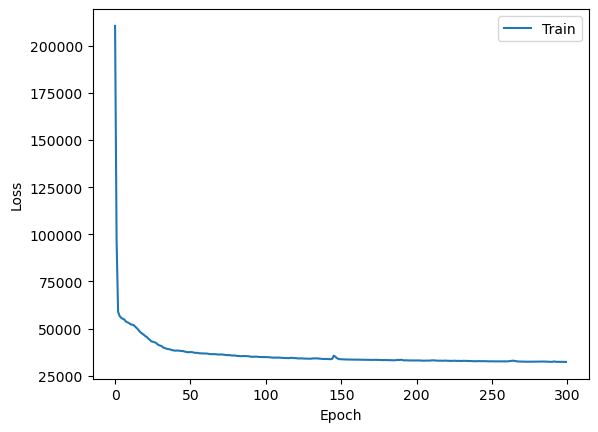

In [12]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Use CVAE model to predict train images

In [17]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[0][0][:50])
#reconstruction = vae.decoder.predict(z[:50])

2/2 [==============================] - 1s 142ms/step


1/1 [==============================] - 1s 883ms/step


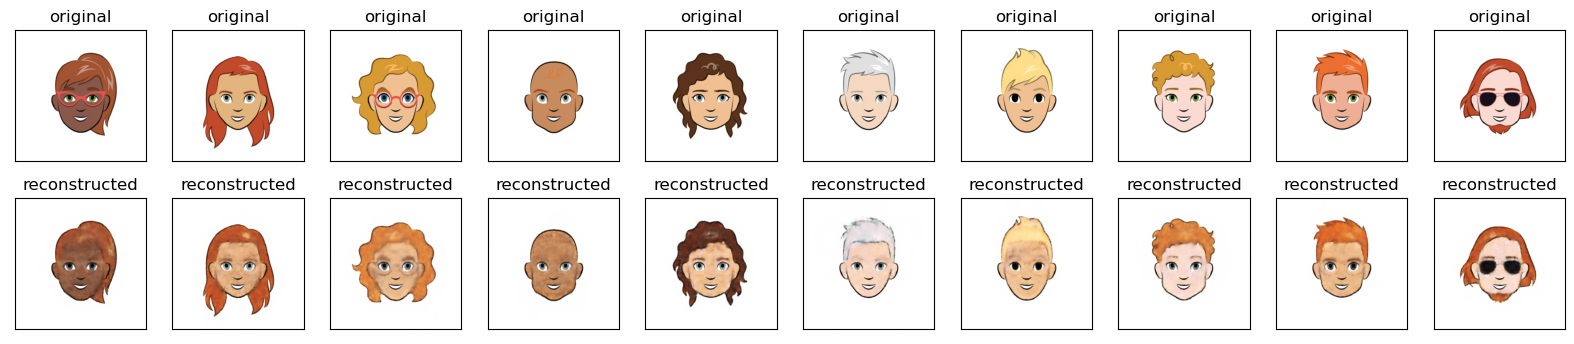

1/1 [==============================] - 0s 53ms/step


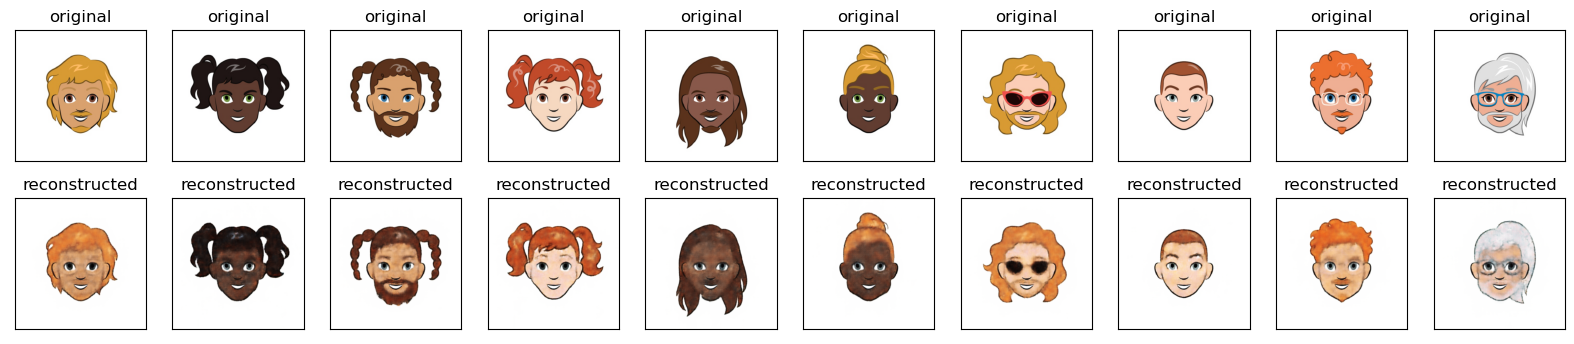

1/1 [==============================] - 0s 94ms/step


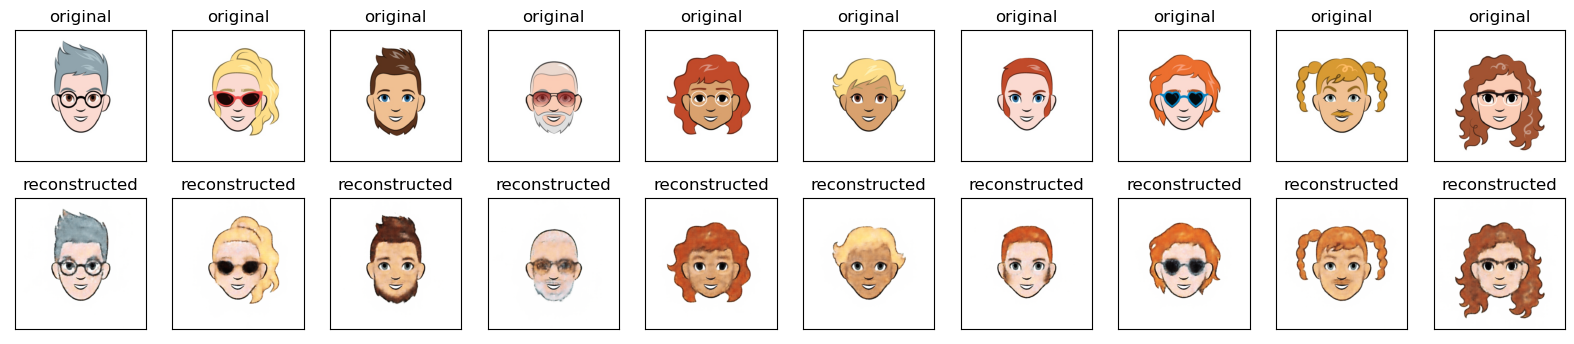

1/1 [==============================] - 0s 47ms/step


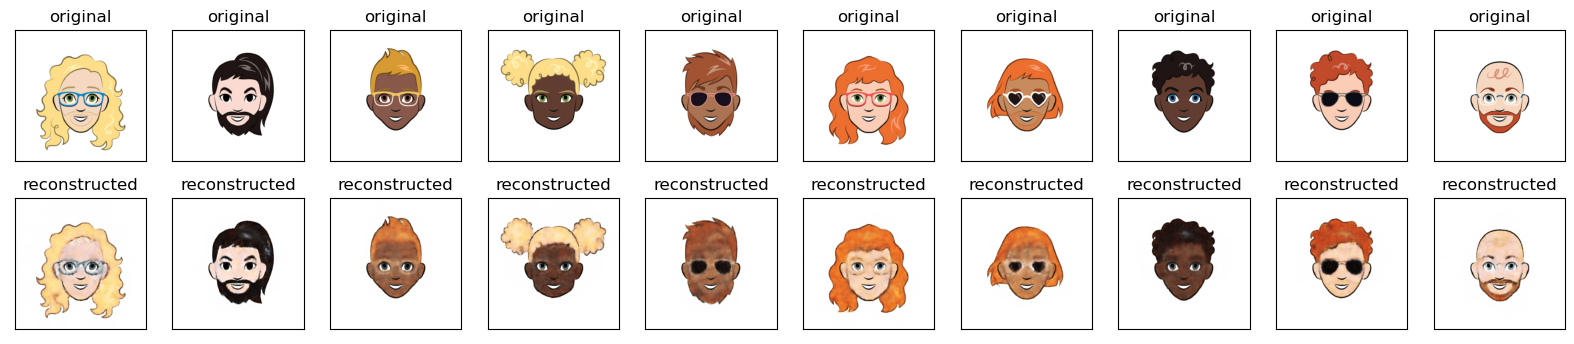

1/1 [==============================] - 0s 78ms/step


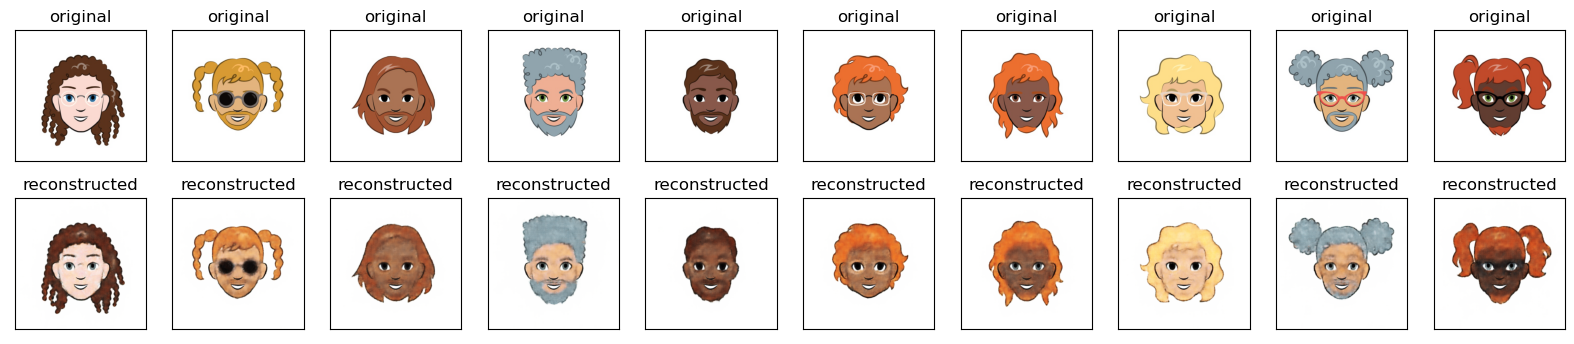

In [18]:
n = 10

for j in ra### Interpolating two images

for i in range(10):    
    face_one_latent = z[np.random.randint(0, 256)]
    face_two_latent = z[np.random.randint(256, 512)]

    f = plt.figure(figsize=(24,16))

    alphaValues = np.linspace(0,1,10)
    plot_index = 1

    for alpha in alphaValues:
        vec = face_one_latent*(1-alpha) + face_two_latent*alpha
        vec = np.reshape(vec, (1, 128))
        decoded = vae.decoder.predict(vec)
        f.add_subplot(1,10,plot_index)
        plt.imshow(np.reshape(decoded,(512,512,3)))
        plot_index +=1
nge(5):
    reconstruction = vae.decoder.predict(z[j*10:(j+1)*10])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data_flow[0][0][i+j*10, :, :, :])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruction[i, :, :,:])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Use CVAE model to predict test images

In [19]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[1][0][:50])
#reconstruction = vae.decoder.predict(z)

2/2 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 48ms/step


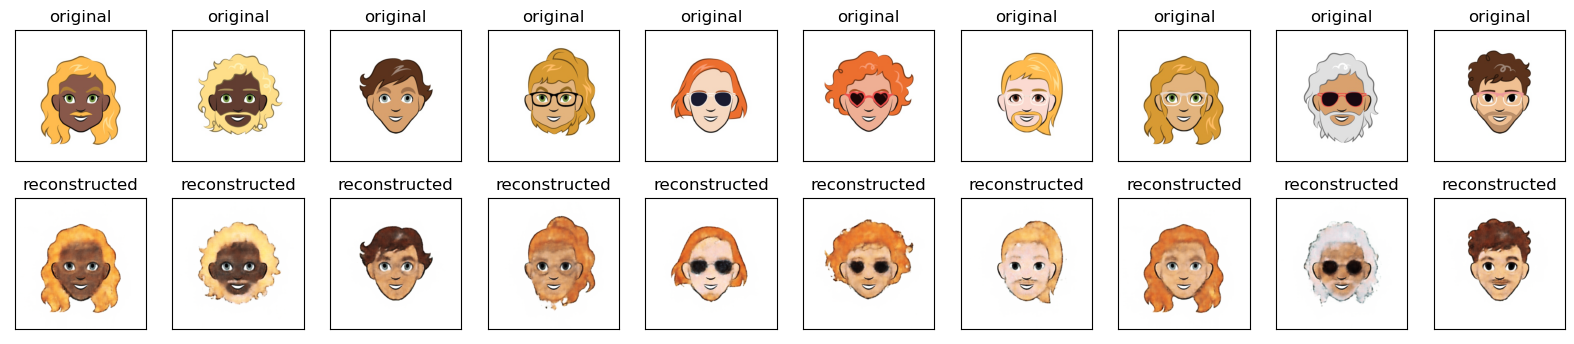

1/1 [==============================] - 0s 47ms/step


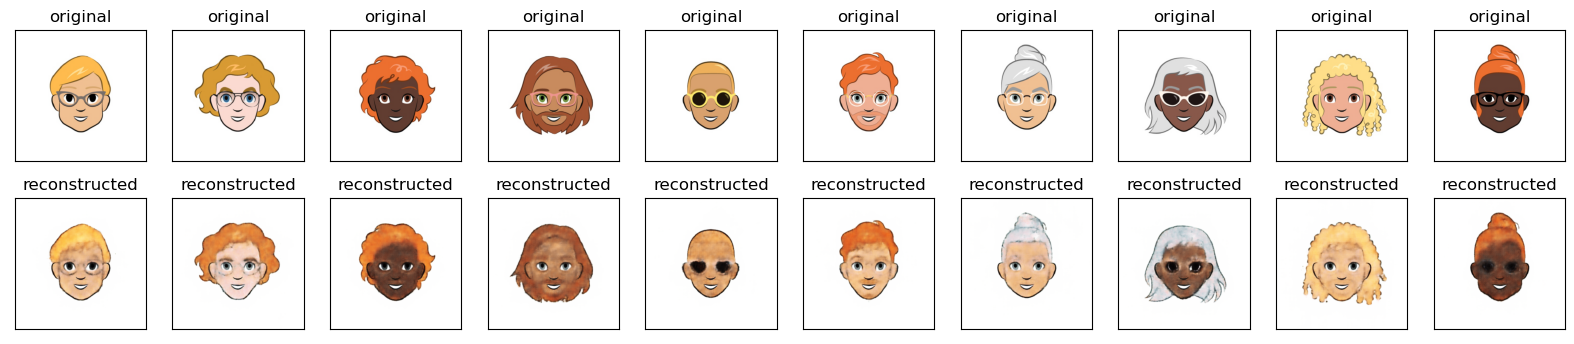

1/1 [==============================] - 0s 47ms/step


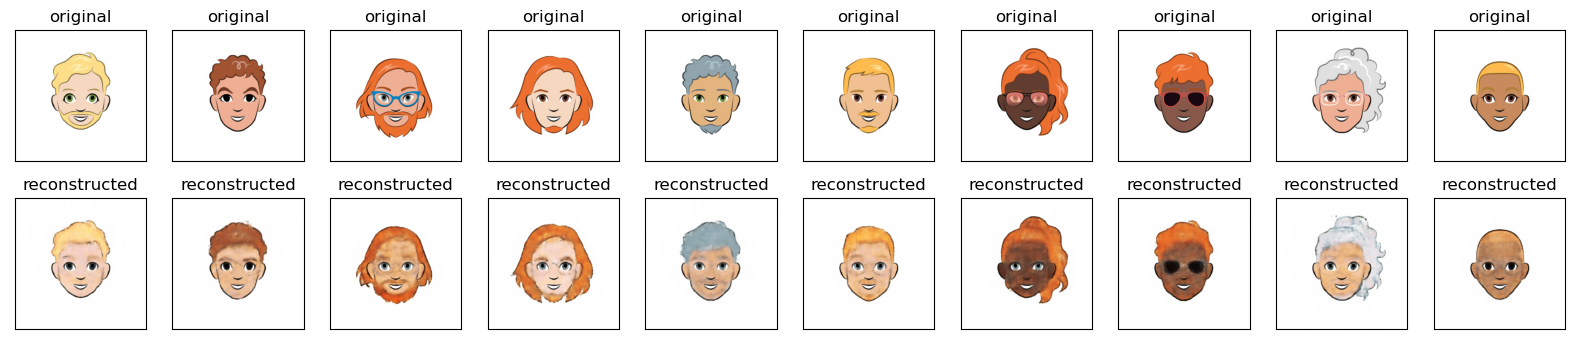

1/1 [==============================] - 0s 55ms/step


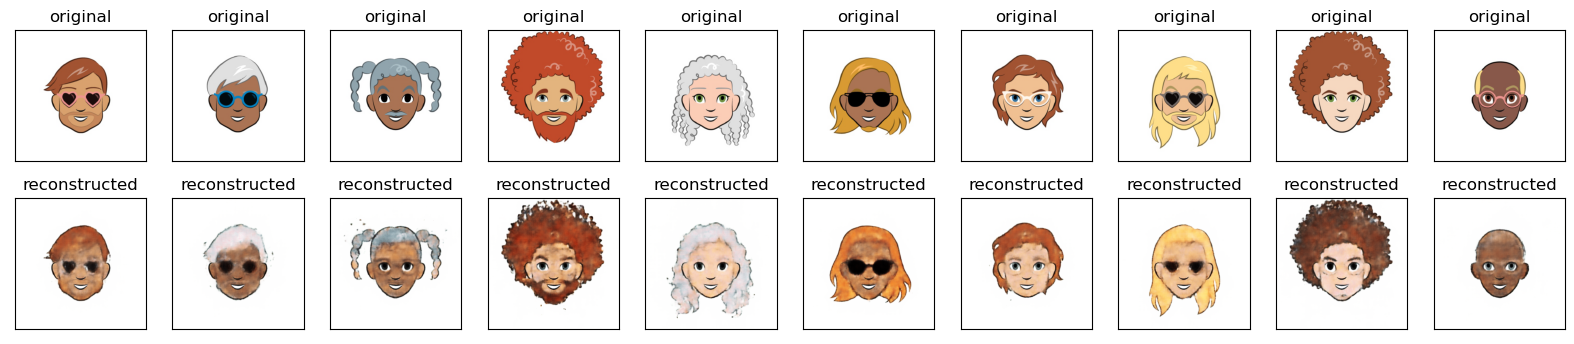

1/1 [==============================] - 0s 48ms/step


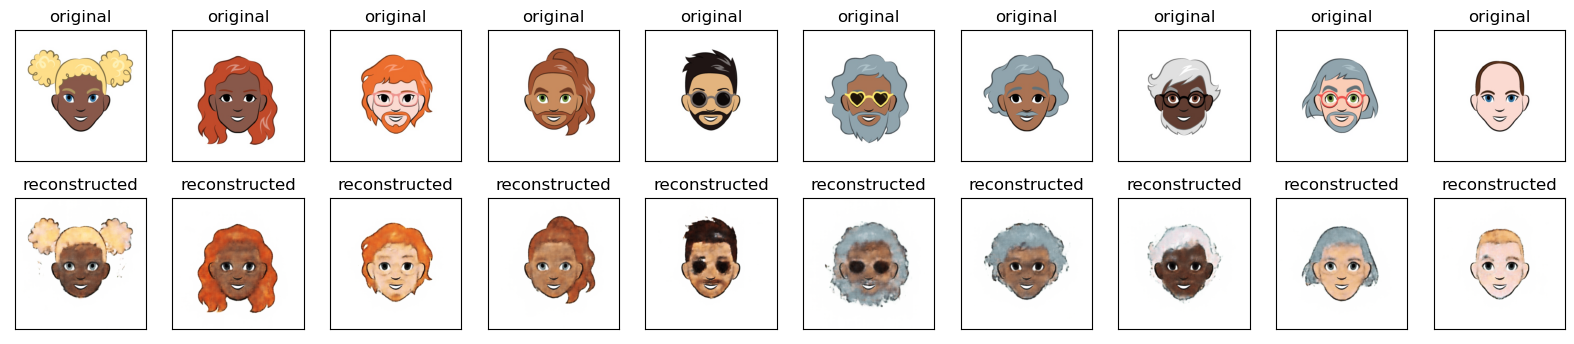

In [20]:


for j in range(5):
    reconstruction = vae.decoder.predict(z[j*10:(j+1)*10])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data_flow[1][0][i+j*10, :, :, :])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruction[i, :, :,:])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Interpolating two images

1/1 [==============================] - 0s 47ms/step


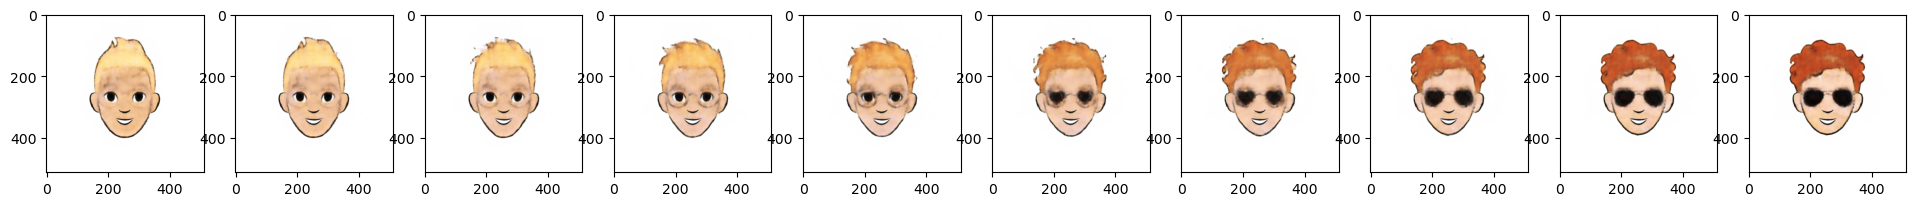

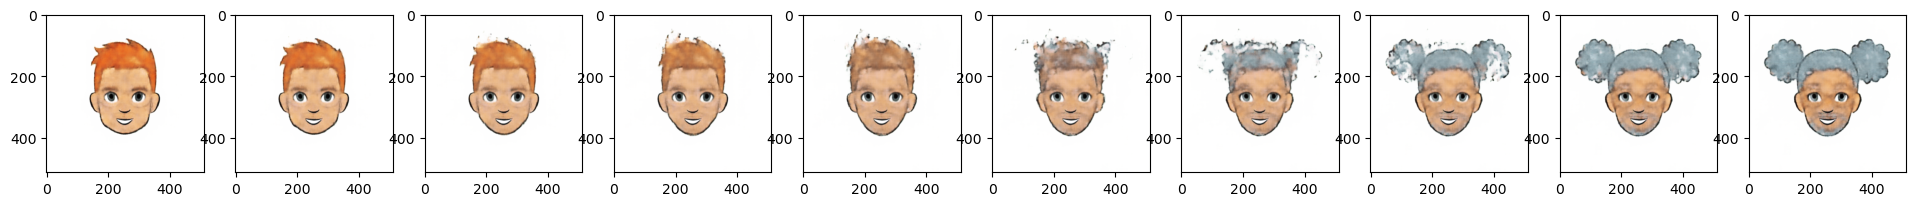

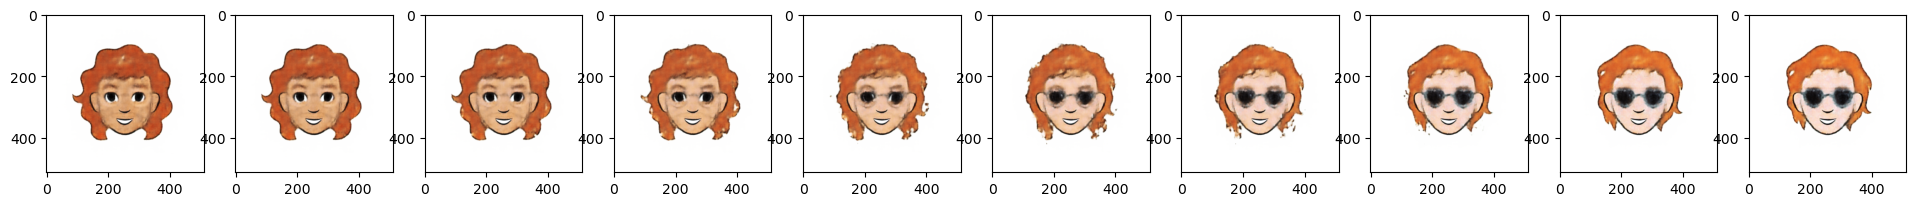

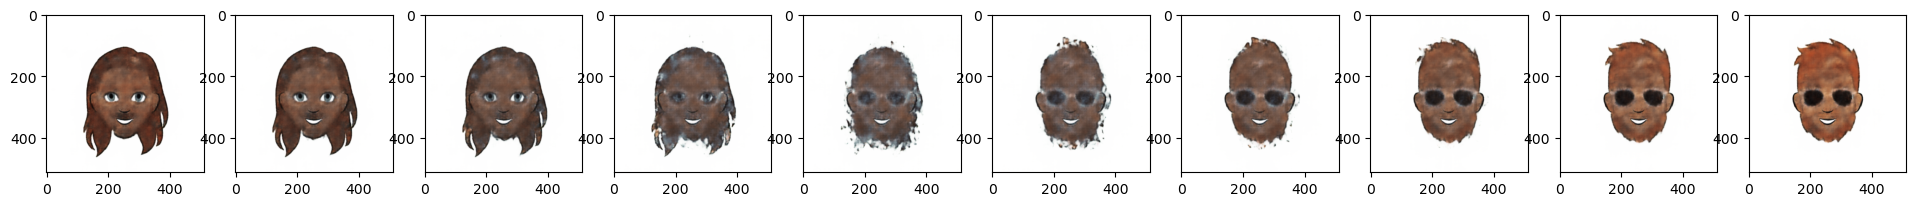

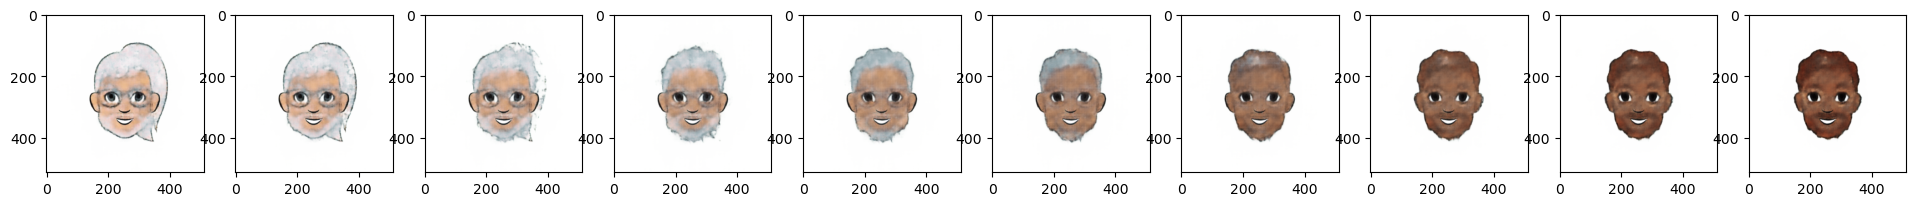

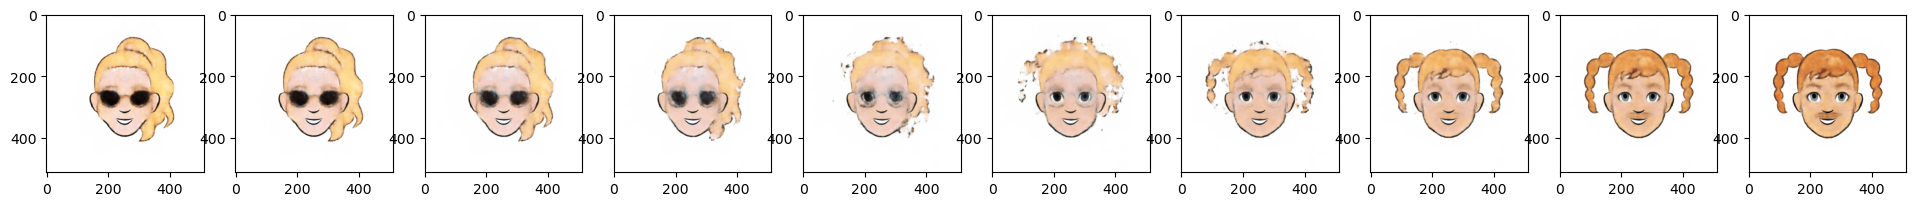

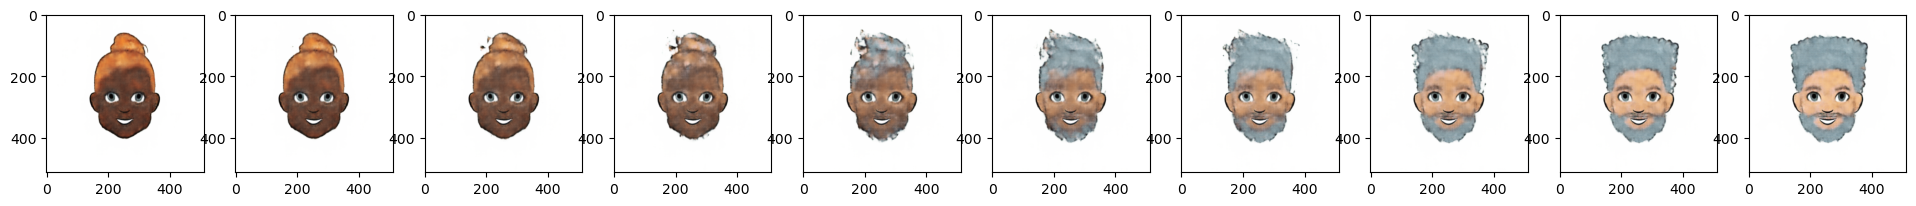

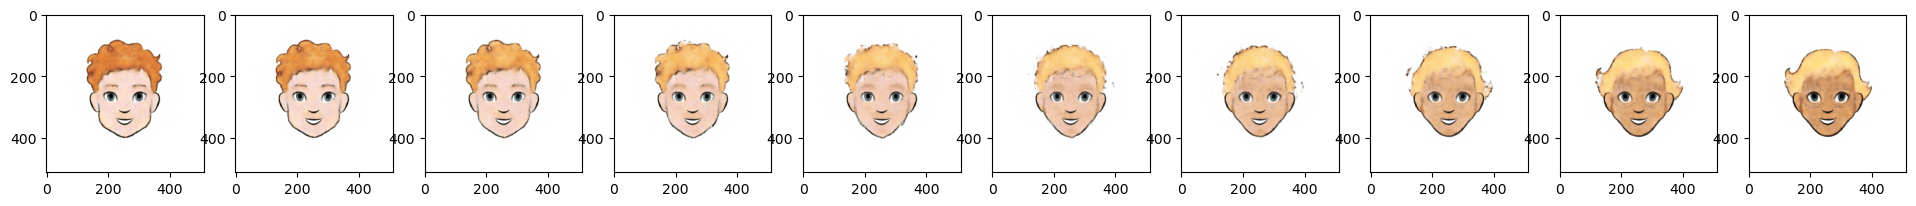

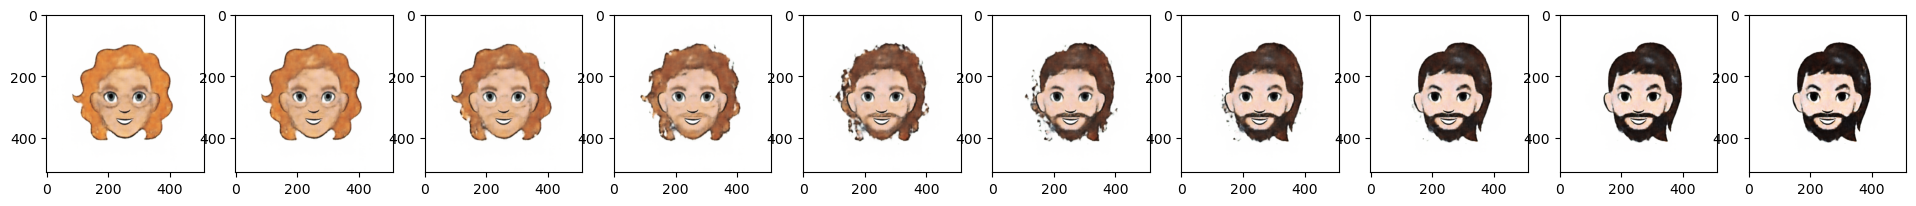

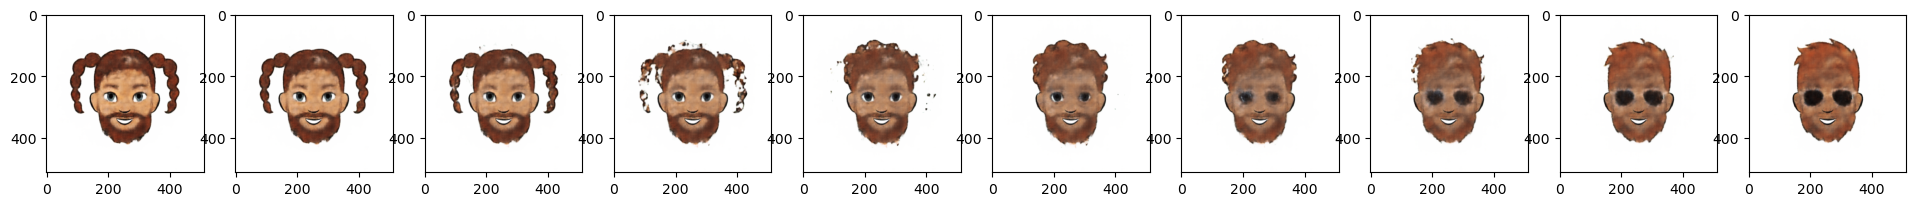

In [22]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[0][0][:50])

for i in range(10):    
    face_one_latent = z[np.random.randint(0, 25)]
    face_two_latent = z[np.random.randint(25, 50)]

    f = plt.figure(figsize=(24,16))

    alphaValues = np.linspace(0,1,10)
    plot_index = 1

    for alpha in alphaValues:
        vec = face_one_latent*(1-alpha) + face_two_latent*alpha
        vec = np.reshape(vec, (1, 128))
        decoded = vae.decoder.predict(vec)
        f.add_subplot(1,10,plot_index)
        plt.imshow(np.reshape(decoded,(512,512,3)))
        plot_index +=1


1/1 [==============================] - 0s 48ms/step


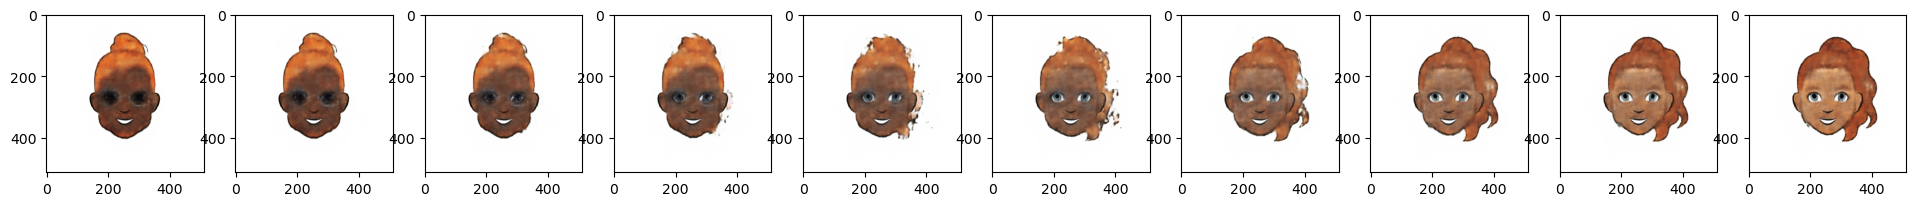

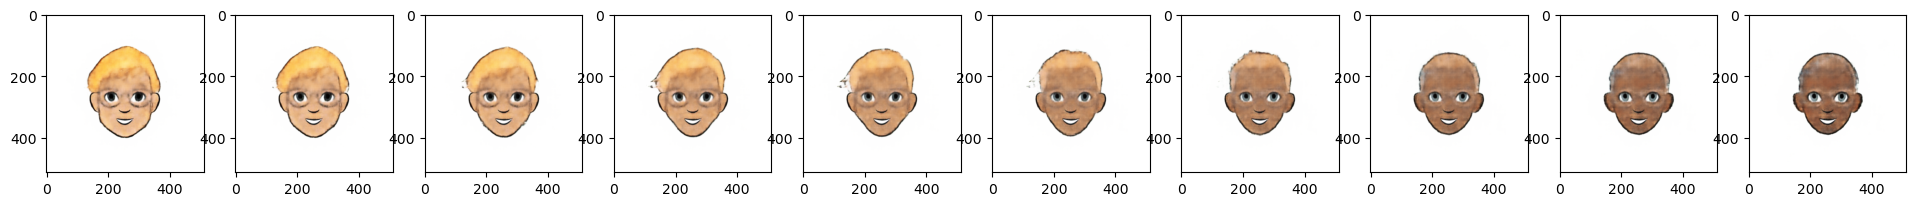

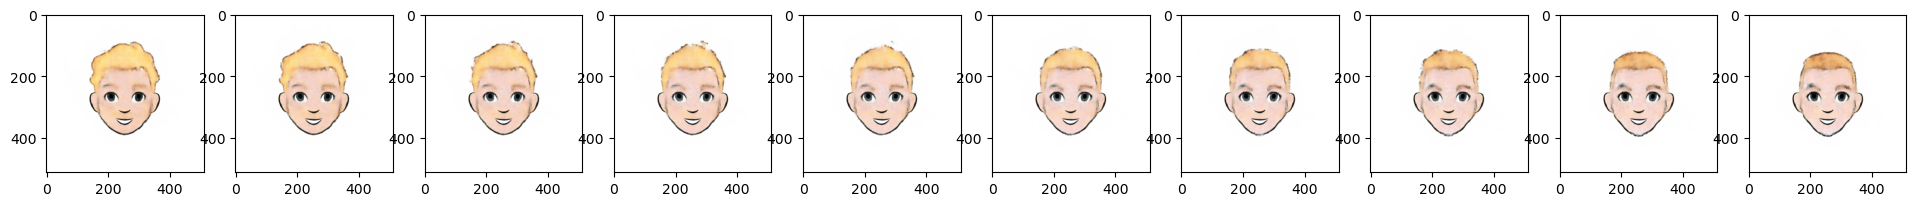

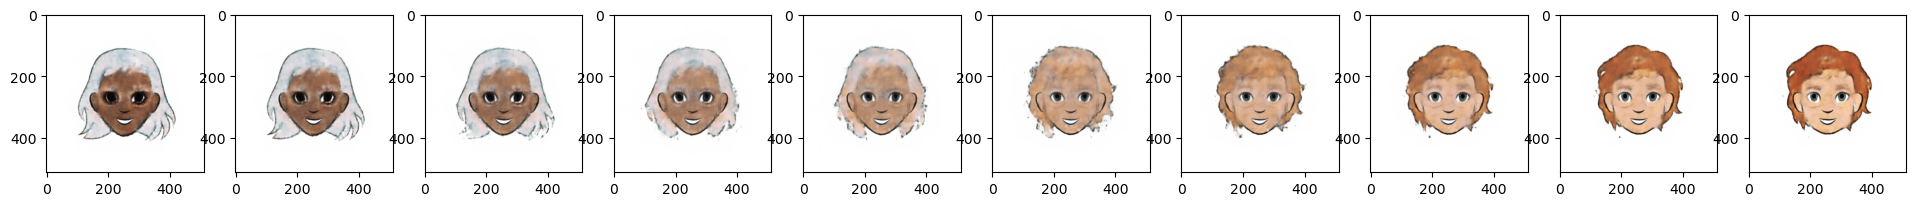

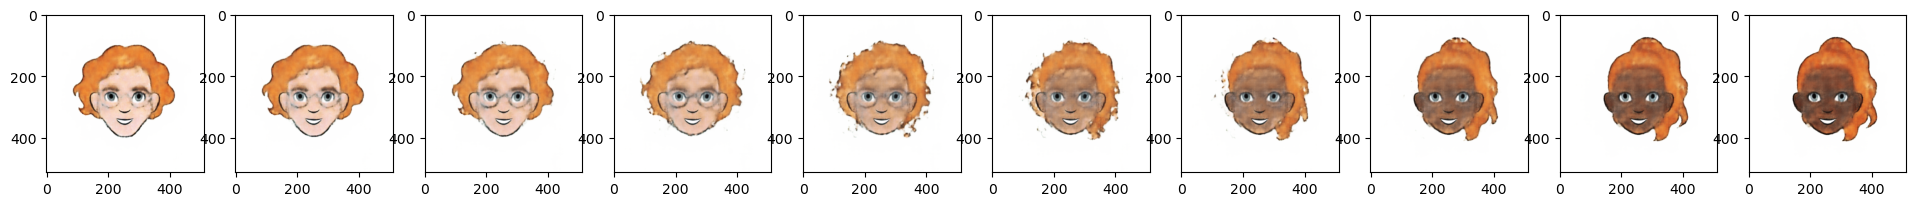

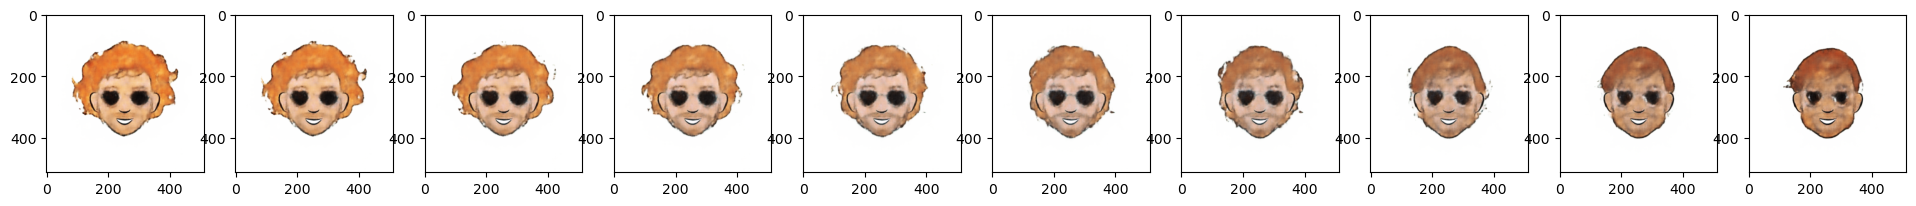

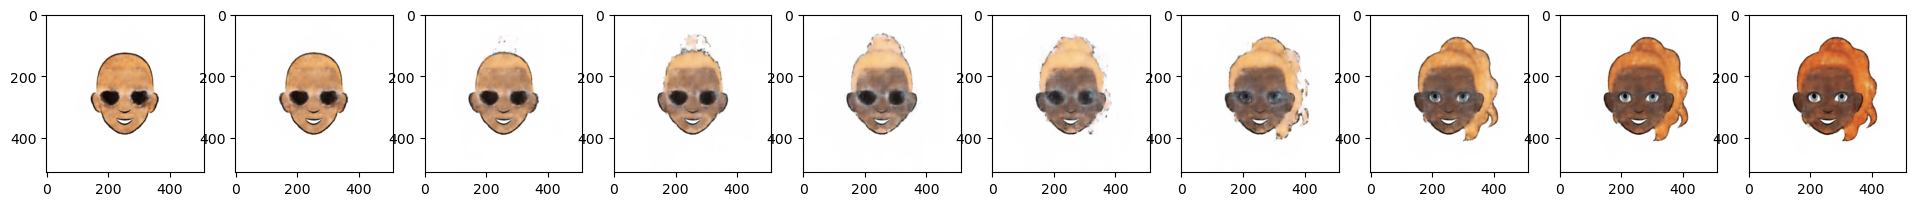

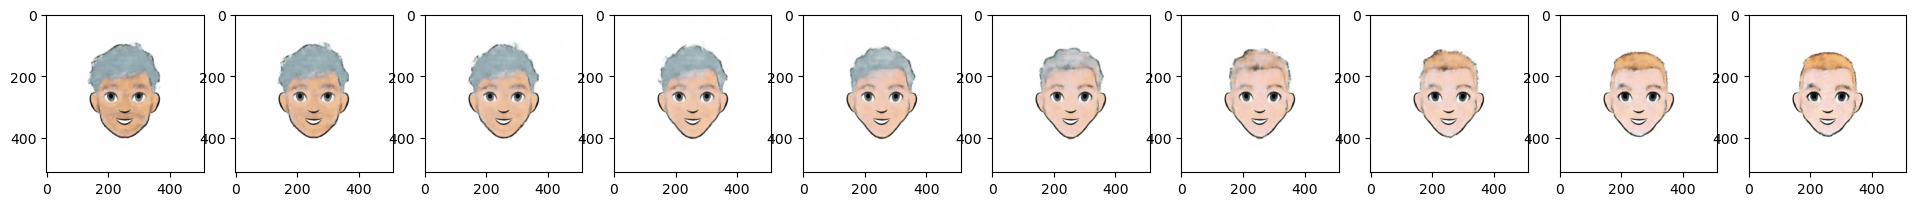

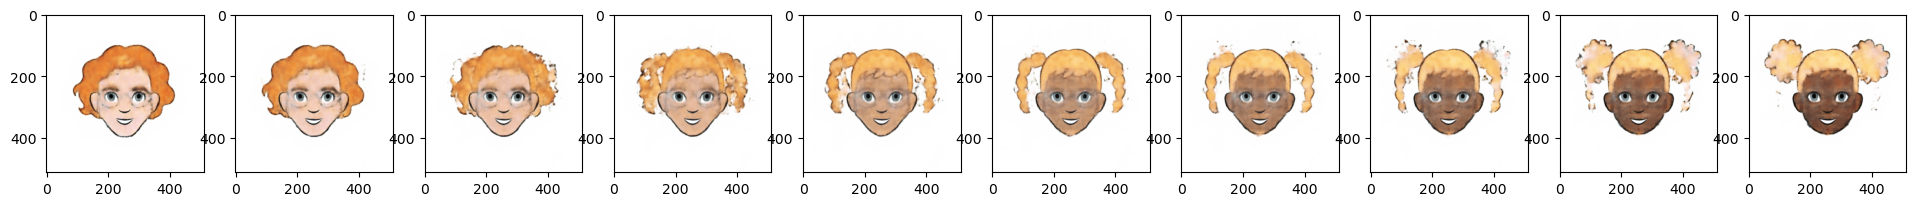

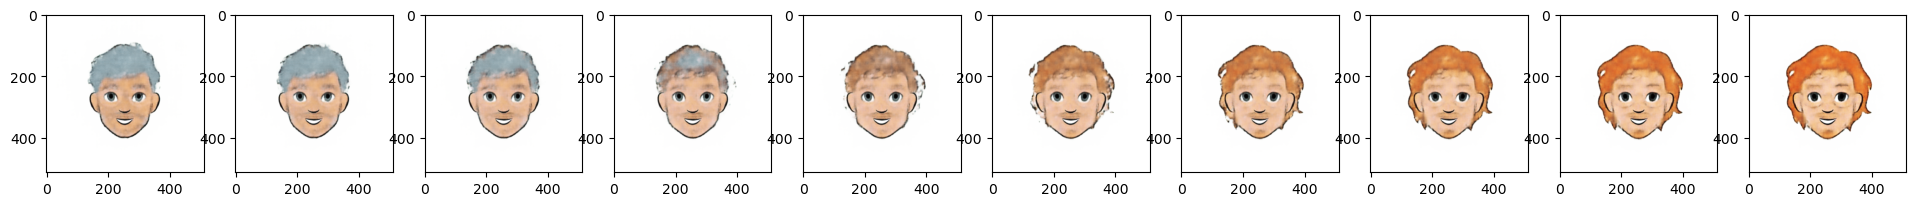

In [23]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[1][0][:50])

for i in range(10):    
    face_one_latent = z[np.random.randint(0, 25)]
    face_two_latent = z[np.random.randint(25, 50)]

    f = plt.figure(figsize=(24,16))

    alphaValues = np.linspace(0,1,10)
    plot_index = 1

    for alpha in alphaValues:
        vec = face_one_latent*(1-alpha) + face_two_latent*alpha
        vec = np.reshape(vec, (1, 128))
        decoded = vae.decoder.predict(vec)
        f.add_subplot(1,10,plot_index)
        plt.imshow(np.reshape(decoded,(512,512,3)))
        plot_index +=1


### Checking out what sort of output we get from noise sampled from normal distribution

1/1 [==============================] - 0s 47ms/step


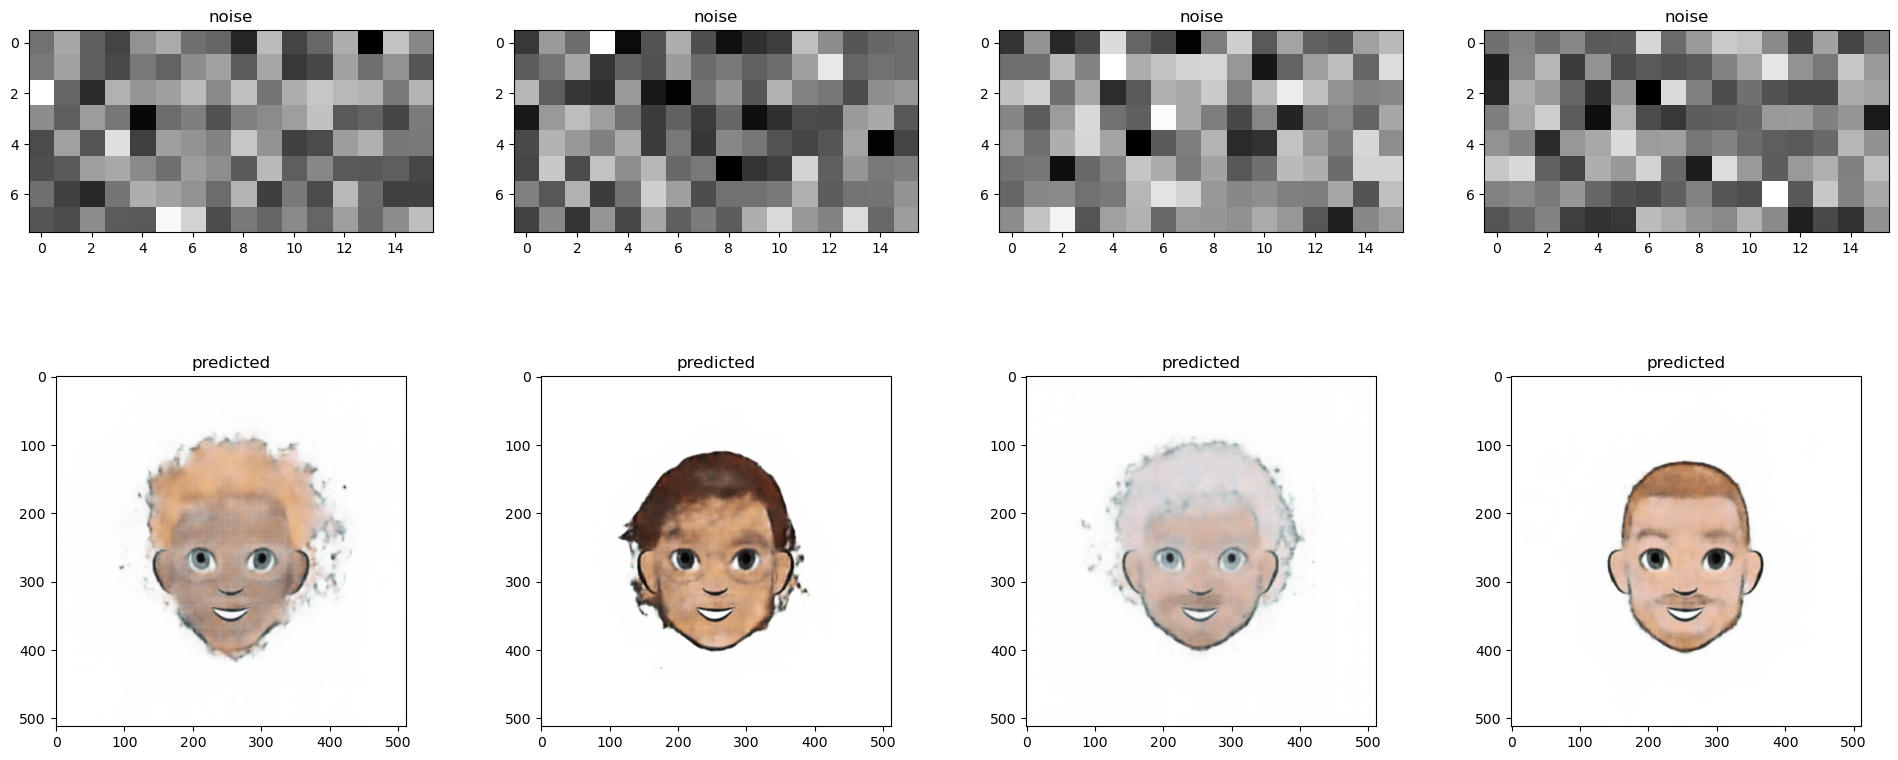

In [25]:

noise = np.random.normal(size=(4,128))
f = plt.figure(figsize=(24,10))

for i in range(4):
    f.add_subplot(2,4,i+5)
    plt.title("predicted")
    pred = vae.decoder.predict(noise)
    plt.imshow(np.reshape(pred[i],(512,512,3)))
    
    f.add_subplot(2,4,i+1)
    plt.title("noise")
    plt.imshow(np.reshape(noise[i], (8,16)))

plt.show()